# Discriminative Sparse Coding

### import libraries

In [72]:
from __future__ import division
import numpy as np
import pandas as pd
import time
import librosa
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import SparseCoder,DictionaryLearning
from sklearn import cluster
# from lightning.regression import CDRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [64]:
class DDSC():
    def __init__(self,train_set,train_sum,gradient_step_size,epsilon,regularization_parameter,steps,n_components,m,T,k):
        """
        Either form is acceptable, but the two should not be mixed. Choose one
        convention to document the __init__ method and be consistent with it.

        Args:
          gradient_step_size (float): gradiant rate for the convergence step for DD (4b).
          epsilon (float) : the gradient stepsize of the pre-training (2b).
          regularization_parameter (float) : weight of penalty function.
          steps (int) : interations to be performed for the convergence part
          param2 (list of str): Description of `param2`. Multiple
            lines are supported.
          param3 (int, optional): Description of `param3`, defaults to 0.

        """
        self.train_set = train_set
        self.train_sum = train_sum
        self.alpha = gradient_step_size
        self.epsilon = epsilon
        self.rp = regularization_parameter
        self.steps = steps
        self.n = n_components
        self.m = m
        self.T = T
        self.k = k

        '''
        Instances that can be used for plotting
        '''
        self.acc_nnsc = None
        self.err_nnsc = None
        self.acc_ddsc = None
        self.err_ddsc = None
        self.a_nnsc = None
        self.b_nnsc = None
        self.a_ddsc = None
        self.b_ddsc = None


################################################################
# will initiualize the matrices A,B with positive values and scale
# columns of B s.t b(j) = 1
    def _initialization(self):

        a = np.random.random((self.n,self.m))
        b = np.random.random((self.T,self.n))

        # scale columns s.t. b_i^(j) = 1
        b /= sum(b)
        return a,b

    # add random positive number to A,B
    # scale columns of b(j)

#################################################################
    def accuracy(self,x,x_sum,B,A):
        '''
        Everything needs to be in lists of ndarrays
        of the components
        '''
        B_cat = np.hstack(B)
        A_cat = np.vstack(A)

        A_prime = self.F(x_sum.values,B_cat,A=A_cat)
        A_last = np.split(A_prime,self.k,axis=0)
        x_predict = self.predict(A_last,B)
        acc_numerator = (map(lambda i: (np.minimum( (B[i].dot(A_last[i])).sum() ,
                        (sum(list(x)[i].sum())))) ,
                        range(len(B))))
        acc_denominator = sum(x_predict).sum()
        acc = sum(acc_numerator) / acc_denominator
        acc_numerator = (map(lambda i: (np.minimum( (B[i].dot(A_last[i])).sum() ,
                        (sum(list(x)[i].sum())))) ,
                        range(len(B))))
        acc_denominator = x_sum.values.sum()
        acc_star = sum(acc_numerator) / acc_denominator
        return acc, acc_star

    def get_accuracy_plot(self):
        return self.acc_nnsc, self.acc_ddsc

    def get_error_plot(self):
        return self.err_nnsc, self.err_ddsc

    def get_a(self):
        return self.a_nnsc, self.a_ddsc

    def get_b(self):
        return self.b_nnsc, self.b_ddsc

    def error(self,x,x_sum,B,A):
        '''
        Error for the whole disaggregation part within list, sum the list to get
        the resulting disaggregation
        Parameters : must have x_train as x
        '''
        B_cat = np.hstack(B)
        A_cat = np.vstack(A)

        error = (map(lambda i: ((1.0/2.0)*np.linalg.norm( (x[i]
                       - B[i].dot(A[i]))**2)),range(len(B))))
        A_last_error = self.F(x_sum.values,B_cat,A_cat)
        A_last_error_list = np.split(A_last_error,self.k,axis=0)
        error_star = (map(lambda i: ((1.0/2.0)*np.linalg.norm( (x[i]
                       - B[i].dot(A_last_error_list[i]))**2)),range(len(B))))
        return error, error_star

    def pre_training(self,x):
        # TODO : implement s.t. conditions and frobenius norm to the options
        tic = time.time()
        #the NON NEGATIVE SPARSE CODING
        A_list,B_list = self.nnsc(x)

        tac = time.time()
        t = tac - tic
        print('time of computations for Dictionary Learning with m: %s and T: %s took: %f' %(self.m,self.T,t))
        return A_list,B_list
################################################################
    # using only the positive values
    @staticmethod
    def _pos_constraint(a):
        indices = np.where(a < 0.0)
        a[indices] = 0.0
        return a
#################################################################
    def nnsc(self,appliances):
        '''
        Method as in NNSC from nonnegative sparse coding finland.
        from P.Hoyer
        TODO:
        implement the coordinate descent algorithm, as of now we are using         gradient descent (not as efficient)
        Also create multiple ndarrays that we take the argmin for.
        '''
        epsilon = 0.01
        acc_nnsc = []
        err_nnsc = []
        a_nnsc = []
        b_nnsc = []
        # used for F
        x_train_sum = self.train_set.values()
        A_list = []
        B_list = []
        for x in appliances:
            A,B = self._initialization()
            Ap = A
            Bp = B
            Ap1 = Ap
            Bp1 = Bp
            t = 0
            change = 1
            while t <= self.steps and self.epsilon <= change:
                # 2a
                Bp = Bp - self.alpha*np.dot((np.dot(Bp,Ap) - x),Ap.T)
                # 2b
                Bp = self._pos_constraint(Bp)
                # 2c
                Bp /= sum(Bp)
                # element wise division
                dot2 = np.divide(np.dot(Bp.T,x),(np.dot(np.dot(Bp.T,Bp),Ap) + self.rp))
                # 2d
                Ap = np.multiply(Ap,dot2)


                change = np.linalg.norm(Ap - Ap1)
                change2 = np.linalg.norm(Bp - Bp1)
                Ap1 = Ap
                Bp1 = Bp
                t += 1
                print("NNSC change is %s for iter %s, and B change is %s" %(change,t,change2))

            print("Gone through one appliance")
            A_list.append(Ap)
            B_list.append(Bp)


        # for thesis
        acc_iter = self.accuracy(x_train_sum,self.train_sum,B_list,A_list)
        err_iter = self.error(x_train_sum,self.train_sum,B_list,A_list)
        acc_nnsc.append(acc_iter)
        err_nnsc.append(err_iter)
        # append norm of matrices
        a_nnsc.append(np.linalg.norm(sum(A_list)))
        b_nnsc.append(np.linalg.norm(sum(B_list)))

        self.acc_nnsc = acc_nnsc
        self.err_nnsc = err_nnsc
        self.a_nnsc = a_nnsc
        self.b_nnsc = b_nnsc
        return A_list,B_list
#################################################################
    def F(self,x,B,x_train=None,A=None,rp_tep=False,rp_gl=False):
        '''
        input is lists of the elements
        output list of elements
        '''
        # 4b
        B = np.asarray(B)
        A = np.asarray(A)
        coder = SparseCoder(dictionary=B.T,
                            transform_alpha=self.rp, transform_algorithm='lasso_cd')
        comps, acts = librosa.decompose.decompose(x,transformer=coder)
        acts = self._pos_constraint(acts)

        return acts
#################################################################
    def DD(self,x,B,A):
        '''
        Taking the parameters as x_train_use and discriminate over the
        entire region
        '''
        # 3.
        A_star = np.vstack(A)
        B_cat = np.hstack(B)
        change = 1
        t = 0
        acc_ddsc = []
        err_ddsc = []
        a_ddsc = []
        b_ddsc = []
        x_train_sum = self.train_set.values()
        while t <= self.steps and self.epsilon <= change:
            B_cat_p = B_cat
            # 4a
            acts = self.F(x,B_cat,A=A_star)
            # 4b
            B_cat = (B_cat-self.alpha*((x-B_cat.dot(acts))
                     .dot(acts.T) - (x-B_cat.dot(A_star)).dot(A_star.T)))
            # 4c
            # scale columns s.t. b_i^(j) = 1
            B_cat = self._pos_constraint(B_cat)
            B_cat /= sum(B_cat)

            # convergence check
            acts_split = np.split(acts,self.k,axis=0)
            B_split = np.split(B_cat,self.k,axis=1)
            acc_iter = self.accuracy(x_train_sum,self.train_sum,B,acts_split)
            acc_iter = self.accuracy(x_train_sum,self.train_sum,B_split,A)
            err_iter = self.error(x_train_sum,self.train_sum,B,acts_split)
            acc_ddsc.append(acc_iter)
            err_ddsc.append(err_iter)
            a_ddsc.append(np.linalg.norm(acts))
            b_ddsc.append(np.linalg.norm(B_cat))

            change = np.linalg.norm(B_cat - B_cat_p)
            t += 1
            print("DD change is %f and step is %d" %(change,t))

        self.acc_ddsc = acc_ddsc
        self.err_ddsc = err_ddsc
        self.a_ddsc = a_ddsc
        self.b_ddsc = b_ddsc
        return B_cat

#################################################################
    def predict(self,A,B):
        x = map(lambda x,y: x.dot(y),B,A)
        return x

In [65]:
np.random.random((0, 2))

array([], shape=(0, 2), dtype=float64)

In [67]:
from __future__ import division
import numpy as np
import pandas as pd
import time
import librosa
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import SparseCoder,DictionaryLearning
from sklearn import cluster
# from lightning.regression import CDRegressor
import matplotlib.pyplot as plt

import os
import sys
import pandas as pd
from collections import defaultdict
import glob

In [68]:
def read_data():
    df = pd.DataFrame()
    houses = []
    path = "datasets/*.csv"
    for fname in glob.glob(path):
        house_df = pd.read_csv(fname)
        houseID = int(fname.split('.')[0].split('\\')[1])
        
        house_df['DateTime'] = pd.to_datetime(house_df['DateTime'])
        mask = (house_df['DateTime'] >= '2014-1-1') & (house_df['DateTime'] < '2015-1-1')
        house_df = house_df.loc[mask]
        house_df = house_df.set_index('DateTime')
        house_df = house_df.resample('1H').first()  # resample from 15 mins to 1 hour 
        house_df = house_df.reset_index(drop=False)
        
        if len(house_df) == 8760 and house_df.isnull().sum().sum() <= 100: # one year hours 
            houses.append(houseID)
            house_df.columns = ['localhour', 'use', 'air1', 'furnace1', 'dishwasher1', 'regrigerator1']  
            house_df = house_df.fillna(method='pad') 
            house_df['regrigerator1'] = house_df['regrigerator1'].fillna(method='ffill')
            appliances_sum = house_df[['air1', 'furnace1', 'dishwasher1', 'regrigerator1']].sum(axis=1)
            house_df['other'] = house_df['use'].subtract(appliances_sum)
            house_df['house'] = houseID
            house_df = house_df.set_index('house')
           
            df = pd.concat([df, house_df])
                               
    return df, houses

df, houses = read_data()
df.head()

,localhour,use,air1,furnace1,dishwasher1,regrigerator1,other
house,,,,,,,
135,2014-01-01 00:00:00,1.043,0.840,0.064,0.0,0.0,0.139
135,2014-01-01 01:00:00,0.158,0.000,0.009,0.0,0.0,0.149
135,2014-01-01 02:00:00,1.097,0.759,0.060,0.0,0.0,0.278
135,2014-01-01 03:00:00,0.715,0.522,0.045,0.0,0.0,0.148
135,2014-01-01 04:00:00,0.111,0.000,0.009,0.0,0.0,0.102


In [69]:
def format_data(df, houses):
    '''
    Parameters: dataframe of the apppliacnes
    Return: dictionary contains all X^T x m
    '''
    d = {}
    for appliance in df.columns.tolist():
        started = 0
        for i in houses:
            if started == 0:

                d[str(appliance)] = df[[str(appliance)]][df[str(appliance)].index == i]
                started = 1
                dfindex = d[str(appliance)].index
    
            else:
                d[str(appliance)][str(i)] = pd.Series(df[str(appliance)][df[str(appliance)].index == i].values,index=dfindex)


        d[str(appliance)]=d[str(appliance)].rename(columns = {str(appliance):str(dfindex[0])})
        d[str(appliance)].reset_index(drop=True, inplace=True)
    return d
    
dic = format_data(df, houses)

In [70]:
def split(d,portion,timeframe, portion_houses=None, option=None):
    '''
    Parameters: d = dictionary, portion 0.5 - 0.9, timeframe 1-8760

    Return: x_train,x_test dictionarys containing dataframes of all the appliances within the timeframe.
    '''

    x_train = {}
    x_test = {}
    timeframe = range(timeframe)
    columns = list(d.keys())
    train_list  = timeframe[int(len(timeframe) * 0.0):int(len(timeframe) * portion)]
    test_list = timeframe[int(len(timeframe) * portion):int(len(timeframe) * 1.0)]
    '''
    start_day_2014 = 3 # thursday
    if option == 'week':
        for key in d.keys():
            x_train[key] = d[key].loc
    '''
    if portion_houses != None:
        houses  = columns[int(len(columns) * 0.0): int(len(columns) * portion_houses)]

    for key in d.keys():

        if portion_houses != None:
            x_train[key] = d[key].loc[train_list,houses]
            x_test[key] = d[key].loc[test_list,houses]
        else:
            x_train[key] = d[key].loc[train_list,:]
            x_test[key] = d[key].loc[test_list,:]

    return x_train,x_test

In [73]:
factor_n_t = 5 # heuristically determined

timeframes = [14,30,60]
timeframes = [48]
#timeframes = [x*24 for x in timeframes]
alphas = [0.0001]
#alphas = [0.0001, 0.00001, 0.000001]
portion = 0.5
# Good values (t,n,alpha)
# (14,40, alpha = 0.0001)
# (336,800, alpha = 0.00001)
# (720,,1400, alpha = )
for timeframe, alpha in zip(timeframes,alphas):
    n = int(factor_n_t*timeframe)
    x_train, x_test = split(d,portion,timeframe,portion_houses=None)
# use in whole house disaggregation step
    x_train_use = x_train.pop('use',None)
    x_test_use = x_test.pop('use',None)
    x_train_localhour = x_train.pop('localhour',None)
    x_test_localhour = x_test.pop('localhour',None)
# algorithm starts

    # parameters
    train_set = x_train
    test_set = x_test
    train_sum = sum(x_train.values())
    k = len(x_train.keys())
    T,m = x_train[list(x_train.keys())[0]].shape
    rp = 0.0005
    epsilon = 0.001
    alpha = 0.0001
    steps = 100 # steps must be higher than k
    # get data
    n_components = n

    # Sparse Coding pre_training
    sc = DDSC(train_set,train_sum,alpha,epsilon,rp,steps,n_components,m,T,k)
    print("started the pre-training")
    A_list,B_list = sc.pre_training(x_train.values())
    print("done pre_training")
    # Discriminative Disaggregation training
    B_cat = sc.DD(x_train_use.values,B_list,A_list)
    print("done DD")
    # Given test examples x_test
    A_prime = sc.F(x_test_use.values,B_cat,A=np.vstack(A_list))
    A_last = np.split(A_prime,k,axis=0)
    x_predict = sc.predict(A_last,B_list)
    x_predict_sum = sum(x_predict)
    print("the shape of the first predicted appliances is :%s" %(x_predict[0].shape,))
    # energy disaggregation accuracy
    acc = sc.accuracy(x_train.values(),train_sum,B_list,A_last)
    # energy disaggregation error
    error, error_star = sc.error(x_train.values(),train_sum,B_list,A_list)
    print("error: %s, error_star: %s" % (sum(error),sum(error_star)))
    acc_nnsc, acc_ddsc = sc.get_accuracy_plot()
    err_nnsc, err_ddsc = sc.get_error_plot()
    # plotting acc/err
    a_nnsc, a_ddsc = sc.get_a()
    b_nnsc, b_ddsc = sc.get_b()

started the pre-training
NNSC change is 18.015906302225936 for iter 1, and B change is 0.047327919433583325
NNSC change is 0.05430130512566751 for iter 2, and B change is 3.2717110343413645e-05
NNSC change is 0.05741044230412295 for iter 3, and B change is 3.5638380076607136e-05
NNSC change is 0.06037574833321639 for iter 4, and B change is 3.964958807425597e-05
NNSC change is 0.06298226696711147 for iter 5, and B change is 4.444707747919231e-05
NNSC change is 0.06490882780504859 for iter 6, and B change is 4.9850035555354836e-05
NNSC change is 0.06600455574135419 for iter 7, and B change is 5.5685529737652405e-05
NNSC change is 0.06625844600708534 for iter 8, and B change is 6.179353764483708e-05
NNSC change is 0.06575536374629311 for iter 9, and B change is 6.803236753489305e-05
NNSC change is 0.06463117809749767 for iter 10, and B change is 7.42829807845187e-05
NNSC change is 0.06303668468654967 for iter 11, and B change is 8.0450960446349e-05
NNSC change is 0.06111355193568855 for 

TypeError: 'map' object is not subscriptable

In [95]:
x_predict[0]

TypeError: 'map' object is not subscriptable

In [78]:


print("the shape of the first predicted appliances is :%s" %(x_predict[0].shape,))

TypeError: 'map' object is not subscriptable

In [96]:
x_train.keys()

dict_keys(['air1', 'furnace1', 'dishwasher1', 'regrigerator1', 'other'])

In [134]:
#x_predict = sc.predict(A_last,B_list)
x_predict = sc.predict(A_list,B_list)

print(np.asarray(list(x_predict)[0])[0:,house])

[0.13206744 0.35100311 0.15976946 0.17129812 0.33181279 0.26605383
 0.14854074 0.3197648  0.12301935 0.11872201 0.12574727 0.17826869
 0.1799241  0.13339441 0.14907132 0.17858734 0.17844497 0.20462458
 0.18144603 0.23761901 0.12899721 0.15440851 0.10705008 0.25514842]


Text(0.5, 0, 'Hours')

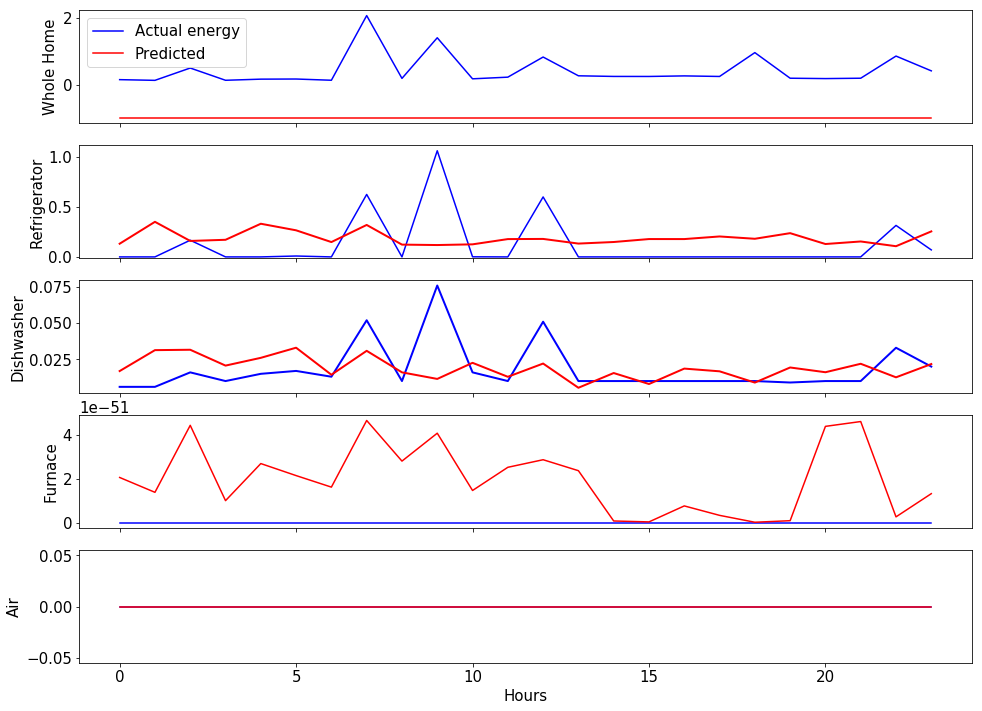

In [141]:
# row and column sharing
house = 0
f, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(5, 1, sharex='col', sharey='row', figsize=(16,12))
x = range(x_train[list(x_train.keys())[0]].shape[0])
plt.rcParams.update({'font.size': 15})

y = np.asarray(x_test_use)[0:,house]
ax1.plot(x, y, color='b',label='Actual energy')
y=[-1]*x_train[list(x_train.keys())[0]].shape[0]
ax1.plot(x, y, color='r', label='Predicted')
#ax1.set_ylim([0,2])
ax1.set_ylabel('Whole Home')
ax1.legend()
##
y = np.asarray(x_test[list(x_test.keys())[0]])[0:,house]
ax2.plot(x, y, color='b')

x_predict = sc.predict(A_list,B_list)
y = np.asarray(list(x_predict)[0])[0:,house]

ax2.plot(x , y, color='r', linewidth=2)
#ax2.get_yaxis().set_visible(False)
ax2.set_ylabel('Refrigerator')
ax2.set_ylim(-0.01)
##
y = np.asarray(x_test[list(x_test.keys())[1]])[0:,house]
ax3.plot(x, y, color='b', linewidth=2)

x_predict = sc.predict(A_list,B_list)
y = np.asarray(list(x_predict)[1])[0:,house]
ax3.plot(x,y, color='r', linewidth=2)
#ax3.get_yaxis().set_visible(False)
ax3.set_ylabel('Dishwasher')
#ax3.set_ylim(-0.00001)

##
y = np.asarray(x_test[list(x_test.keys())[2]])[0:,house]
ax4.plot(x, y, color='b')

x_predict = sc.predict(A_list,B_list)
y = np.asarray(list(x_predict)[2])[0:,house]
ax4.plot(x,y, color='r')
#ax4.get_yaxis().set_visible(False)
ax4.set_ylabel('Furnace')

##
y = np.asarray(x_test[list(x_test.keys())[3]])[0:,house]
ax5.plot(x, y, color='b')

x_predict = sc.predict(A_list,B_list)
y = np.asarray(list(x_predict)[3])[0:,house]
ax5.plot(x,y, color='r')
#ax5.get_yaxis().set_visible(False)
ax5.set_ylabel('Air')
ax5.set_xlabel('Hours')